In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler  


In [27]:
data = pd.read_excel('data-stiffness_SS.xlsx') 

# remove rows with null value
data = data.dropna(how='any',axis=0) 

# select features and target variable
features = data.iloc[:, :-2]  # all columns except the last two

#target = data.iloc[:, -2:-1]     # stiffness
target = data.iloc[:, -1]     # specific stiffness

X_train, X_valid, y_train, y_valid =train_test_split(features, target , test_size = 0.25,random_state=0, shuffle=True)


In [3]:
# Feature scaling
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)  # numpy.ndarray
X_valid = scaler.transform(X_valid)      # numpy.ndarray

In [4]:
#It builds and returns a feedforward neural network (a Sequential model) for regression tasks. 
#The model is customizable via its arguments, such as the number of hidden layers, the number of neurons in each layer, 
#and the learning rate for optimization.

def build_model(n_hidden , n_neurons, learning_rate, shape, active_fun):
    model = keras.models.Sequential()  
    model.add(keras.layers.InputLayer(shape=shape))  
    for layer in range(n_hidden):     
        model.add(keras.layers.Dense(n_neurons , activation=active_fun)) 
    model.add(keras.layers.Dense(1))  
    optimizer= keras.optimizers.Adam(learning_rate=learning_rate)  
    model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])
    return model

In [5]:
# Build keras model
model = build_model(n_hidden=4 , n_neurons=52, learning_rate=0.003, shape=[9], active_fun='tanh')


In [6]:
# getting callbacks

early_stopping = keras.callbacks.EarlyStopping(patience=20,
                                              restore_best_weights=False)       #patience: Number of epochs with no improvement after which training will be stopped. Defaults to 0.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("My_trained_model.keras",
                                                     save_best_only=False,
                                                     monitor='val_loss',
                                                     verbose=1)

In [7]:
h = model.fit(X_train , y_train, epochs=1000,
             validation_data=(X_valid, y_valid),
             callbacks=[model_checkpoint,early_stopping])
# h = model.fit(X_train , y_train, epochs=200,
#              validation_data=(X_valid, y_valid))

Epoch 1/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.4913 - mse: 0.4913
Epoch 1: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2270 - mse: 0.2270 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 2/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0243 - mse: 0.0243
Epoch 2: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 3/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0153 - mse: 0.0153
Epoch 3: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 4/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0080 - mse: 0.0080
Epoch 4: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 5/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss:

Epoch 28/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0031 - mse: 0.0031
Epoch 28: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 29/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0016 - mse: 0.0016
Epoch 29: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 30/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0013 - mse: 0.0013
Epoch 30: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 31/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0013 - mse: 0.0013
Epoch 31: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 32/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/ste

Epoch 55/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0017 - mse: 0.0017
Epoch 55: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 56/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.4862e-04 - mse: 7.4862e-04
Epoch 56: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 57/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011 - mse: 0.0011
Epoch 57: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 58/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0015 - mse: 0.0015
Epoch 58: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 59/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 82/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.8799e-04 - mse: 6.8799e-04
Epoch 82: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4984e-04 - mse: 7.4984e-04 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 83/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0013 - mse: 0.0013
Epoch 83: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 84/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4232e-04 - mse: 8.4232e-04
Epoch 84: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 85/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0029 - mse: 0.0029
Epoch 85: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 86/1000
 1/18 ━━━━━━━━

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011 - mse: 0.0011
Epoch 108: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2495e-04 - mse: 9.2495e-04 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 109/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0011 - mse: 0.0011
Epoch 109: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 110/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.4978e-04 - mse: 3.4978e-04
Epoch 110: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 111/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0021 - mse: 0.0021
Epoch 111: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 112/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 6.4026e-04 - mse: 6.4026e-04
Epoch 134: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 135/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.9760e-04 - mse: 3.9760e-04
Epoch 135: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 136/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0010 - mse: 0.0010
Epoch 136: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 137/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.4530e-04 - mse: 6.4530e-04
Epoch 137: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9703e-04 - mse: 7.9703e-04 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 138/1000
 1/18 ━━━━━━

Epoch 160/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.0950e-04 - mse: 6.0950e-04
Epoch 160: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2092e-04 - mse: 6.2092e-04 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 161/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.2079e-04 - mse: 5.2079e-04
Epoch 161: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0699e-04 - mse: 6.0699e-04 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 162/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.2336e-04 - mse: 6.2336e-04
Epoch 162: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9239e-04 - mse: 5.9239e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 163/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.4401e-04 - mse: 4.4401e-04
Epoch 163: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0045e-04 - mse: 5.0045e-04 - val_loss: 0.001

Epoch 186/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.3075e-04 - mse: 2.3075e-04
Epoch 186: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4693e-04 - mse: 3.4693e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 187/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8769e-04 - mse: 1.8769e-04
Epoch 187: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2640e-04 - mse: 4.2640e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 188/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.8945e-04 - mse: 2.8945e-04
Epoch 188: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2701e-04 - mse: 3.2701e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 189/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.1612e-04 - mse: 3.1612e-04
Epoch 189: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5633e-04 - mse: 3.5633e-04 - val_loss: 0.001

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0008e-04 - mse: 7.0008e-04 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 212/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.7639e-04 - mse: 6.7639e-04
Epoch 212: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3731e-04 - mse: 7.3731e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 213/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.6099e-04 - mse: 4.6099e-04
Epoch 213: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.4754e-04 - mse: 8.4754e-04 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 214/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0012 - mse: 0.0012
Epoch 214: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0667e-04 - mse: 8.0667e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 215/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.1110e-04 - mse: 4.1110e-04
Epoch 215: saving model to My_trained_

Epoch 237/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5144e-04 - mse: 1.5144e-04
Epoch 237: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3301e-04 - mse: 2.3301e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 238/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.7676e-04 - mse: 2.7676e-04
Epoch 238: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6355e-04 - mse: 2.6355e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 239/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.1615e-04 - mse: 1.1615e-04
Epoch 239: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2184e-04 - mse: 3.2184e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 240/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.7829e-04 - mse: 4.7829e-04
Epoch 240: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8783e-04 - mse: 3.8783e-04 - val_loss: 0.001

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.2643e-04 - mse: 1.2643e-04
Epoch 262: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1164e-04 - mse: 3.1164e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 263/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.6199e-04 - mse: 5.6199e-04
Epoch 263: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7456e-04 - mse: 4.7456e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 264/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.6185e-04 - mse: 3.6185e-04
Epoch 264: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6000e-04 - mse: 7.6000e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 265/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.9026e-04 - mse: 3.9026e-04
Epoch 265: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7189e-04 - mse: 5.7189e-04 - val_loss: 0.0019 - val_mse: 0.

Epoch 288/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.4796e-04 - mse: 3.4796e-04
Epoch 288: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1245e-04 - mse: 3.1245e-04 - val_loss: 9.2967e-04 - val_mse: 9.2967e-04
Epoch 289/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.4900e-04 - mse: 1.4900e-04
Epoch 289: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5890e-04 - mse: 1.5890e-04 - val_loss: 9.2573e-04 - val_mse: 9.2573e-04
Epoch 290/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.2392e-04 - mse: 1.2392e-04
Epoch 290: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1837e-04 - mse: 2.1837e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 291/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.3289e-04 - mse: 6.3289e-04
Epoch 291: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6381e-04 - mse: 3.6381e-04 -

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.1480e-04 - mse: 5.1480e-04
Epoch 313: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7775e-04 - mse: 7.7775e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 314/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.0774e-04 - mse: 5.0774e-04
Epoch 314: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 315/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.0015e-04 - mse: 7.0015e-04
Epoch 315: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 316/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0017 - mse: 0.0017
Epoch 316: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 317/1000
 1/18 ━━━━━━

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.5932e-04 - mse: 1.5932e-04
Epoch 338: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1053e-04 - mse: 3.1053e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 339/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.9754e-04 - mse: 5.9754e-04
Epoch 339: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7187e-04 - mse: 5.7187e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 340/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.6707e-04 - mse: 1.6707e-04
Epoch 340: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5337e-04 - mse: 3.5337e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 341/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.8682e-04 - mse: 3.8682e-04
Epoch 341: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8803e-04 - mse: 3.8803e-04 - val_loss: 8.0908e-04 - val_mse

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3581e-04 - mse: 1.3581e-04
Epoch 363: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5982e-04 - mse: 1.5982e-04 - val_loss: 7.8286e-04 - val_mse: 7.8286e-04
Epoch 364/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.3611e-04 - mse: 1.3611e-04
Epoch 364: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6440e-04 - mse: 1.6440e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 365/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.0911e-04 - mse: 2.0911e-04
Epoch 365: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7869e-04 - mse: 1.7869e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 366/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.8003e-04 - mse: 4.8003e-04
Epoch 366: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6967e-04 - mse: 3.6967e-04 - val_loss: 9.3612e-04 -

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.6120e-05 - mse: 4.6120e-05
Epoch 388: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5584e-05 - mse: 8.5584e-05 - val_loss: 7.4502e-04 - val_mse: 7.4502e-04
Epoch 389/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0128e-04 - mse: 1.0128e-04
Epoch 389: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2699e-04 - mse: 1.2699e-04 - val_loss: 7.8997e-04 - val_mse: 7.8997e-04
Epoch 390/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.8826e-05 - mse: 9.8826e-05
Epoch 390: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8659e-04 - mse: 1.8659e-04 - val_loss: 8.1074e-04 - val_mse: 8.1074e-04
Epoch 391/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.3198e-04 - mse: 1.3198e-04
Epoch 391: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7719e-04 - mse: 1.7719e-04 - val_lo

Epoch 414/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.6742e-04 - mse: 1.6742e-04
Epoch 414: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9227e-04 - mse: 1.9227e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 415/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.7670e-04 - mse: 2.7670e-04
Epoch 415: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5861e-04 - mse: 2.5861e-04 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 416/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.9099e-04 - mse: 2.9099e-04
Epoch 416: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1704e-04 - mse: 2.1704e-04 - val_loss: 9.5476e-04 - val_mse: 9.5476e-04
Epoch 417/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.0405e-04 - mse: 2.0405e-04
Epoch 417: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0753e-04 - mse: 2.0753e-04 - val_los

Epoch 439/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.7843e-05 - mse: 7.7843e-05
Epoch 439: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3557e-04 - mse: 1.3557e-04 - val_loss: 8.6264e-04 - val_mse: 8.6264e-04
Epoch 440/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.7129e-04 - mse: 1.7129e-04
Epoch 440: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0359e-04 - mse: 1.0359e-04 - val_loss: 7.8741e-04 - val_mse: 7.8741e-04
Epoch 441/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.1005e-05 - mse: 7.1005e-05
Epoch 441: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8510e-05 - mse: 8.8510e-05 - val_loss: 7.6182e-04 - val_mse: 7.6182e-04
Epoch 442/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0327e-04 - mse: 1.0327e-04
Epoch 442: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.4467e-05 - mse: 9.44

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.0984e-04 - mse: 6.0984e-04
Epoch 464: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7104e-04 - mse: 5.7104e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 465/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.6597e-04 - mse: 2.6597e-04
Epoch 465: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2809e-04 - mse: 3.2809e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 466/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.9984e-04 - mse: 3.9984e-04
Epoch 466: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2671e-04 - mse: 3.2671e-04 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 467/1000
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.0473e-04 - mse: 4.0473e-04
Epoch 467: saving model to My_trained_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6238e-04 - mse: 4.6238e-04 - val_loss: 0.0012 - val_mse: 0.

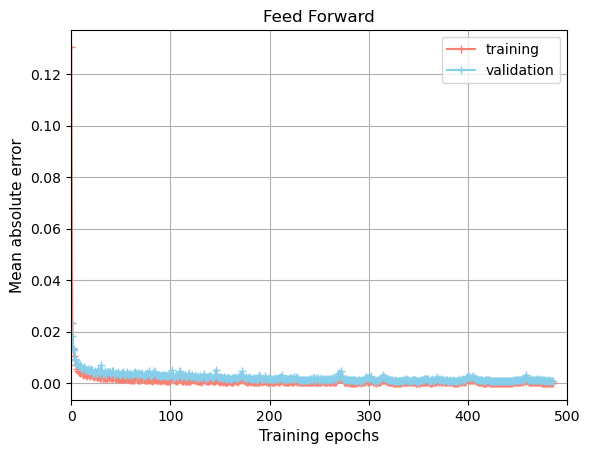

In [86]:
import matplotlib.pyplot as plt
plt.plot(h.history['loss'], "+-", label='training', color = "salmon")
plt.plot(h.history['val_loss'], "+-", label='validation', color = "skyblue")
plt.legend(fontsize=10) 
plt.title('Feed Forward')
plt.grid()
plt.xlabel('Training epochs', fontsize=11)
plt.ylabel('Mean absolute error', fontsize=11)
plt.xlim(0, 500)
plt.show()



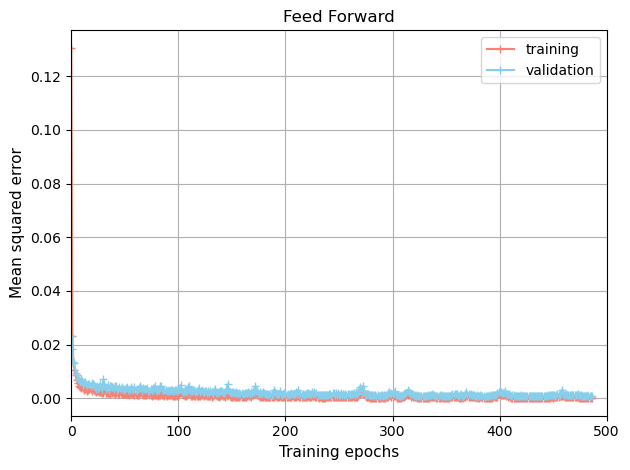

In [85]:
plt.plot(h.history['mse'], "+-", label='training', color = "salmon")
plt.plot(h.history['val_mse'], "+-", label='validation', color = 'skyblue')
plt.legend(fontsize=10) 
plt.title('Feed Forward')
plt.grid()
plt.xlabel('Training epochs', fontsize=11)
plt.ylabel('Mean squared error', fontsize=11)
plt.xlim(0, 500)
plt.tight_layout()
plt.show()

In [34]:
from SALib.sample import saltelli
from SALib.sample import sobol



problem = {
    'num_vars': 9,
    'names': [ 't','theta','theta_hex','plate_N','plate_hex','l_N','h_N','l_P','h_P' ],
    'bounds': [[np.min(data['t']),np.max(data['t'])],
              [np.min(data['theta']),np.max(data['theta'])],
              [np.min(data['theta_hex']),np.max(data['theta_hex'])],
              [np.min(data['plate_N']),np.max(data['plate_N'])],
              [np.min(data['plate_hex']),np.max(data['plate_hex'])],
              [np.min(data['l_N']),np.max(data['l_N'])],
              [np.min(data['h_N']),np.max(data['h_N'])],
              [np.min(data['l_P']),np.max(data['l_P'])],
              [np.min(data['h_P']),np.max(data['h_P'])]]
}

#If `calc_second_order` is False, the resulting matrix has ``N * (D + 2)`` rows, 
#where ``D`` is the number of parameters. If `calc_second_order` is `True`, the resulting matrix has ``N * (2D + 2)`` rows.
param_values = sobol.sample(problem, 4096, calc_second_order = True)    

In [36]:
# Standardize to the predefined normal distribution
column_names = ['t','theta','theta_hex','plate_N','plate_hex','l_N','h_N','l_P','h_P' ]
param_pd = pd.DataFrame(param_values, columns=column_names)

param_values=scaler.transform(param_pd)

In [37]:
#Evaluate the value of the response using the trained model
Y_k = model.predict(param_values) 

Y_k= Y_k.ravel()

2560/2560 ━━━━━━━━━━━━━━━━━━━━ 2s 915us/step


In [74]:
# Perform Sobol Analysis

from SALib.analyze import sobol

Si = sobol.analyze(problem, Y_k)     

C:\Users\fhassani\AppData\Roaming\Python\Python39\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


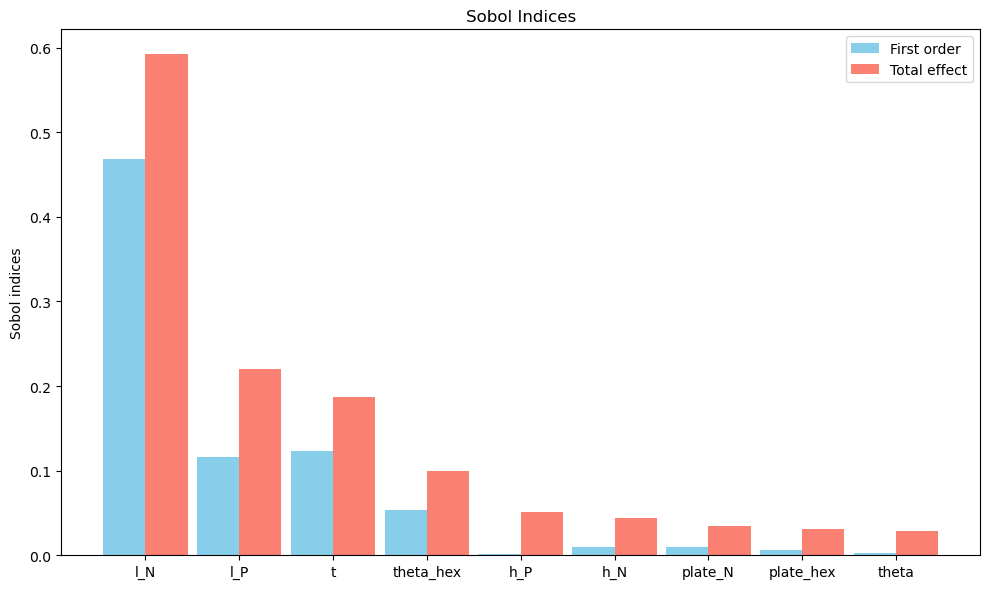

In [83]:
# Parameters and values
parameters = ['t','theta','theta_hex','plate_N','plate_hex','l_N','h_N','l_P','h_P' ]
First_order = [first_Si.iloc[0,0], first_Si.iloc[1,0],first_Si.iloc[2,0], first_Si.iloc[3,0],first_Si.iloc[4,0], first_Si.iloc[5,0], first_Si.iloc[6,0], first_Si.iloc[7,0], first_Si.iloc[8,0]]
Total_effect = [total_Si.iloc[0,0], total_Si.iloc[1,0],total_Si.iloc[2,0], total_Si.iloc[3,0],total_Si.iloc[4,0], total_Si.iloc[5,0],total_Si.iloc[6,0], total_Si.iloc[7,0], total_Si.iloc[8,0]]

# Sort the data by values in descending order
sorted_parameters, sorted_First_order , sorted_Total_effect = zip(*sorted(zip(parameters, First_order,Total_effect), key=lambda x: x[2], reverse=True))


# Bar width and positions
x = np.arange(len(parameters))
bar_width = 0.45

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - bar_width / 2, sorted_First_order, bar_width, label='First order', color='skyblue')
bar2 = ax.bar(x + bar_width / 2, sorted_Total_effect, bar_width, label='Total effect', color='salmon')

# Add labels and title
#ax.set_xlabel('Parameters')
ax.set_ylabel('Sobol indices')
ax.set_title('Sobol Indices')
ax.set_xticks(x)
ax.set_xticklabels(sorted_parameters)
ax.legend()

# Show the chart
plt.tight_layout()
plt.show()